author : Ho Man Cheng
description : for training a facial type model

In [33]:
# import dataset
import pandas as pd
from util import (DATASET_PATH )
import tensorflow 
from tensorflow import keras
from keras import models, layers, optimizers, callbacks, applications as apps
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print(tf.__version__)
# print(tf.keras.__version__)

2.16.1


AttributeError: module 'tensorflow.keras' has no attribute '__version__'

In [2]:
def load_batch_datagen(bat_num):
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2,
    )

    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        directory=f"{DATASET_PATH}/face_shape__batch_{bat_num}/training",
        subset="training",
        target_size=(256, 256),
        class_mode="categorical",
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=f"{DATASET_PATH}/face_shape__batch_{bat_num}/training",
        subset="validation",
        target_size=(256, 256),
        class_mode="categorical",
    )

    test_generator = test_datagen.flow_from_directory(
        directory=f"{DATASET_PATH}/face_shape__batch_{bat_num}/testing",
        target_size=(256, 256),
        class_mode="categorical",
    )

    return train_generator, validation_generator, test_generator

In [34]:
# google net (inception_v4)
def create_model__inception_v3(num_classes):
    """
    # the model creation for resnet-v2 implement
    # since the keras team have not yet anwser the [issue](https://github.com/keras-team/keras/issues/18903)
    # here I manual convert the model from Sequential to Functional based
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.InceptionV3(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    """
    # init
    _input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")
    _applicate_layer = apps.InceptionV3(
        include_top=False, weights="imagenet", pooling="avg"
    )(_input_layer)
    # _flatten_layer = layers.Flatten()(_applicate_layer)
    _dense_layer_1 = layers.Dense(4096, activation="relu", name="dense_layer_1")(
        _applicate_layer
    )
    _dense_layer_2 = layers.Dense(1000, activation="relu", name="dense_layer_2")(
        _dense_layer_1
    )
    _dense_layer_3 = layers.Dense(
        num_classes, activation="softmax", name="predictions"
    )(_dense_layer_2)

    return models.Model(
        inputs=_input_layer, outputs=_dense_layer_3, name="inception_v3_impl"
    )
model_base = create_model__inception_v3(5)

In [35]:
model_base.summary()

Model: "inception_v3_impl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,297,493 (130.83 MB)

 Trainable params: 34,263,061 (130.70 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [36]:
from datetime import datetime

model_base.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["acc"],
)

filepath = "./weights/face_shape__temp_main.{epoch:02d}-{val_loss:.2f}.keras"

checkpoint = callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

# today = datetime.now()

cv_logging = callbacks.CSVLogger(f"./logs/training.csv", separator=",", append=False)

Today's date: 2024_04_15_07_46_35
Current Time: 07-46-35


In [37]:
# for batch in [1,2,3]:
batch = 0
train_generator, validation_generator, test_generator = load_batch_datagen(batch)

history = model_base.fit(
    train_generator,
    steps_per_epoch=50,  # 2000 images = batch_size * steps
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10,  # 1000 images = batch_size * steps
    callbacks=[checkpoint, cv_logging],
)

Found 2800 images belonging to 5 classes.
Found 697 images belonging to 5 classes.
Found 1499 images belonging to 5 classes.
Epoch 1/20


/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - acc: 0.1946 - loss: 2.2447 - val_acc: 0.2188 - val_loss: 1001.1766
Epoch 2/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1969 - loss: 1.6100

2024-05-15 22:08:20.042420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - acc: 0.1941 - loss: 1.6005 - val_acc: 0.1781 - val_loss: 59.2309
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.2010 - loss: 1.6111

2024-05-15 22:10:14.402698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - acc: 0.2011 - loss: 1.6111 - val_acc: 0.1754 - val_loss: 2.0849
Epoch 4/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1970 - loss: 1.6113

2024-05-15 22:11:36.859087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - acc: 0.1963 - loss: 1.6012 - val_acc: 0.2219 - val_loss: 30.4915
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - acc: 0.1952 - loss: 1.6101 - val_acc: 0.1875 - val_loss: 1.6068
Epoch 6/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.2123 - loss: 1.6087

2024-05-15 22:15:00.559565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 22:15:01.416676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.2113 - loss: 1.5989 - val_acc: 0.1404 - val_loss: 2.2353
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.2033 - loss: 1.6129 - val_acc: 0.2344 - val_loss: 1.6204
Epoch 8/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1869 - loss: 1.6117

2024-05-15 22:18:20.366280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - acc: 0.1880 - loss: 1.6019 - val_acc: 0.2000 - val_loss: 1.6095
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.2080 - loss: 1.6115

2024-05-15 22:20:16.800256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - acc: 0.2080 - loss: 1.6115 - val_acc: 0.2281 - val_loss: 4.9387
Epoch 10/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.2002 - loss: 1.6091

2024-05-15 22:21:39.956282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - acc: 0.2025 - loss: 1.5993 - val_acc: 0.2031 - val_loss: 75.5625
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.2175 - loss: 1.6065 - val_acc: 0.2281 - val_loss: 1.6339
Epoch 12/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.1698 - loss: 1.6111

2024-05-15 22:25:04.794420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 22:25:05.643505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.1742 - loss: 1.6011 - val_acc: 0.2281 - val_loss: 1.0761
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.2273 - loss: 1.6089 - val_acc: 0.1937 - val_loss: 1.6102
Epoch 14/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.1925 - loss: 1.6081

2024-05-15 22:28:25.397367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - acc: 0.1933 - loss: 1.5985 - val_acc: 0.2188 - val_loss: 1.6104
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.2123 - loss: 1.6093

2024-05-15 22:30:23.343928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - acc: 0.2122 - loss: 1.6093 - val_acc: 0.2982 - val_loss: 1.0711
Epoch 16/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.2347 - loss: 1.6107

2024-05-15 22:31:45.543203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - acc: 0.2335 - loss: 1.6007 - val_acc: 0.2250 - val_loss: 1.6077
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.2075 - loss: 1.6093 - val_acc: 0.2188 - val_loss: 1.6225
Epoch 18/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.1847 - loss: 1.6166

2024-05-15 22:35:10.592767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 22:35:11.462486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.1865 - loss: 1.6056 - val_acc: 0.2281 - val_loss: 1.0751
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - acc: 0.2033 - loss: 1.6098 - val_acc: 0.2031 - val_loss: 1.6088
Epoch 20/20
38/50 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1817 - loss: 1.6097

2024-05-15 22:38:31.279632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - acc: 0.1815 - loss: 1.5998 - val_acc: 0.2031 - val_loss: 1.6078


In [37]:
model_base.evaluate(test_generator)

/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - acc: 0.2658 - loss: 5.4579


[5.461678504943848, 0.2641761302947998]

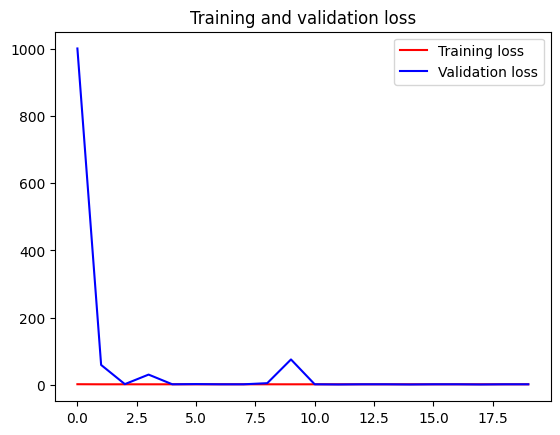

In [38]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [39]:
model_base.save('./face_shape.keras')

In [41]:
import tensorflow as tf
import tf2onnx
import onnx


input_signature = [tf.TensorSpec([None, 256,256, 3], tf.float32, name="x")]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model_base, input_signature, opset=13)
onnx.save(onnx_model, "face_shape_model.onnx")

2024-05-15 23:29:52.145301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 23:29:52.145439: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-15 23:29:52.145509: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-15 23:29:52.145901: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 23:29:52.145961: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

FileNotFoundError: [Errno 2] No such file or directory: 'dst/path/model.onnx'